# 4.1 Universe Filtering

Filter trading universe based on per-symbol model performance on validation set.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import spearmanr

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

DATA_DIR = Path('data')

## 1. Load Data and Model

In [21]:
# Load full dataset
df = pd.read_parquet(DATA_DIR / 'ml_dataset.pqt')
df['date'] = pd.to_datetime(df['feature_date'])
print(f"Total: {len(df):,} rows, {df['symbol'].nunique():,} symbols")
print(f"Date range: {df['date'].min().date()} to {df['date'].max().date()}")

Total: 2,092,929 rows, 3,506 symbols
Date range: 2021-01-13 to 2025-12-18


In [22]:
# Split into train/val/test (same as training notebook)
dates = sorted(df['date'].unique())
n_dates = len(dates)

train_end_idx = int(n_dates * 0.7)
val_end_idx = int(n_dates * 0.8)

train_dates = set(dates[:train_end_idx])
val_dates = set(dates[train_end_idx:val_end_idx])
test_dates = set(dates[val_end_idx:])

val_df = df[df['date'].isin(val_dates)].copy()
print(f"Validation set: {len(val_df):,} rows, {val_df['symbol'].nunique():,} symbols")
print(f"Val dates: {min(val_dates).date()} to {max(val_dates).date()}")

Validation set: 210,247 rows, 2,176 symbols
Val dates: 2024-05-02 to 2024-10-21


In [23]:
# Load model
import sys
sys.path.insert(0, '.')
from trading.model import ModelInference

model = ModelInference(DATA_DIR / 'model_capped.pt')
print(f"Model loaded: {len(model.price_cols)} price, {len(model.fund_cols)} fund, {len(model.emb_cols)} emb features")

Model loaded: 9 price, 19 fund, 768 emb features


In [24]:
# Score validation set
val_df['score'] = model.score(val_df)
print(f"Scored {len(val_df):,} validation samples")

Scored 210,247 validation samples


## 2. Per-Symbol Performance Metrics

In [25]:
def compute_symbol_metrics(group):
    """Compute performance metrics for a single symbol."""
    if len(group) < 10:  # Need minimum samples
        return None
    
    # Spearman IC (rank correlation between score and return)
    ic, _ = spearmanr(group['score'], group['target_return'])
    
    # Directional accuracy (does score direction match return direction?)
    score_sign = np.sign(group['score'] - group['score'].median())
    return_sign = np.sign(group['target_return'] - group['target_return'].median())
    accuracy = (score_sign == return_sign).mean()
    
    # Bottom quintile performance (our short strategy)
    bottom_20_mask = group['score'] <= group['score'].quantile(0.2)
    if bottom_20_mask.sum() > 0:
        bottom_20_return = group.loc[bottom_20_mask, 'target_return'].mean()
    else:
        bottom_20_return = np.nan
    
    # News coverage
    has_news = (group['emb_0'] != 0).mean()  # If embedding is non-zero, has news
    
    return pd.Series({
        'n_samples': len(group),
        'ic': ic,
        'accuracy': accuracy,
        'bottom_20_return': bottom_20_return,
        'news_coverage': has_news,
        'avg_return': group['target_return'].mean(),
        'return_std': group['target_return'].std(),
    })

In [26]:
%%time

# Compute metrics per symbol
symbol_metrics = val_df.groupby('symbol').apply(compute_symbol_metrics).dropna()
print(f"Computed metrics for {len(symbol_metrics):,} symbols")
symbol_metrics.head(10)

Computed metrics for 2,075 symbols
CPU times: user 3.5 s, sys: 30.8 ms, total: 3.54 s
Wall time: 3.61 s


<timed exec>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,n_samples,ic,accuracy,bottom_20_return,news_coverage,avg_return,return_std
symbol,,,,,,,
A,118.0,-0.074666,0.508475,0.002238,0.271186,-0.000208,0.017307
AA,118.0,-0.058707,0.440678,0.008457,0.347458,0.001385,0.030610
AAL,118.0,0.028084,0.508475,-0.004447,0.813559,-0.000553,0.026561
AAOI,118.0,-0.017964,0.457627,-0.007312,0.194915,0.004338,0.062108
AAON,118.0,0.019257,0.474576,0.001396,0.161017,0.001522,0.024720
AAPL,118.0,-0.075499,0.440678,0.002342,1.000000,0.002602,0.015795
AB,39.0,-0.188462,0.384615,-0.000423,0.333333,-0.001623,0.016638
ABBV,118.0,-0.159956,0.440678,0.003430,0.864407,0.001389,0.012112
ABCB,118.0,0.047163,0.542373,0.003832,0.177966,0.002318,0.019026


In [27]:
# Summary statistics
print("Per-Symbol Metric Summary:")
print(symbol_metrics.describe())

Per-Symbol Metric Summary:
         n_samples           ic     accuracy  bottom_20_return  news_coverage  \
count  2075.000000  2075.000000  2075.000000       2075.000000    2075.000000   
mean    101.107470     0.030760     0.506624         -0.002329       0.165758   
std      32.884086     0.120976     0.059630          0.019427       0.226593   
min      10.000000    -0.597059     0.000000         -0.236109       0.000000   
25%     108.500000    -0.039186     0.474576         -0.003537       0.000000   
50%     118.000000     0.027628     0.508475         -0.000014       0.076271   
75%     118.000000     0.098437     0.542373          0.002934       0.250000   
max     118.000000     0.642105     0.809524          0.150714       1.000000   

        avg_return   return_std  
count  2075.000000  2075.000000  
mean     -0.000870     0.028927  
std       0.009781     0.031184  
min      -0.178052     0.002015  
25%      -0.000861     0.015712  
50%       0.000702     0.021310  
75%  

## 3. Analyze Metric Distributions

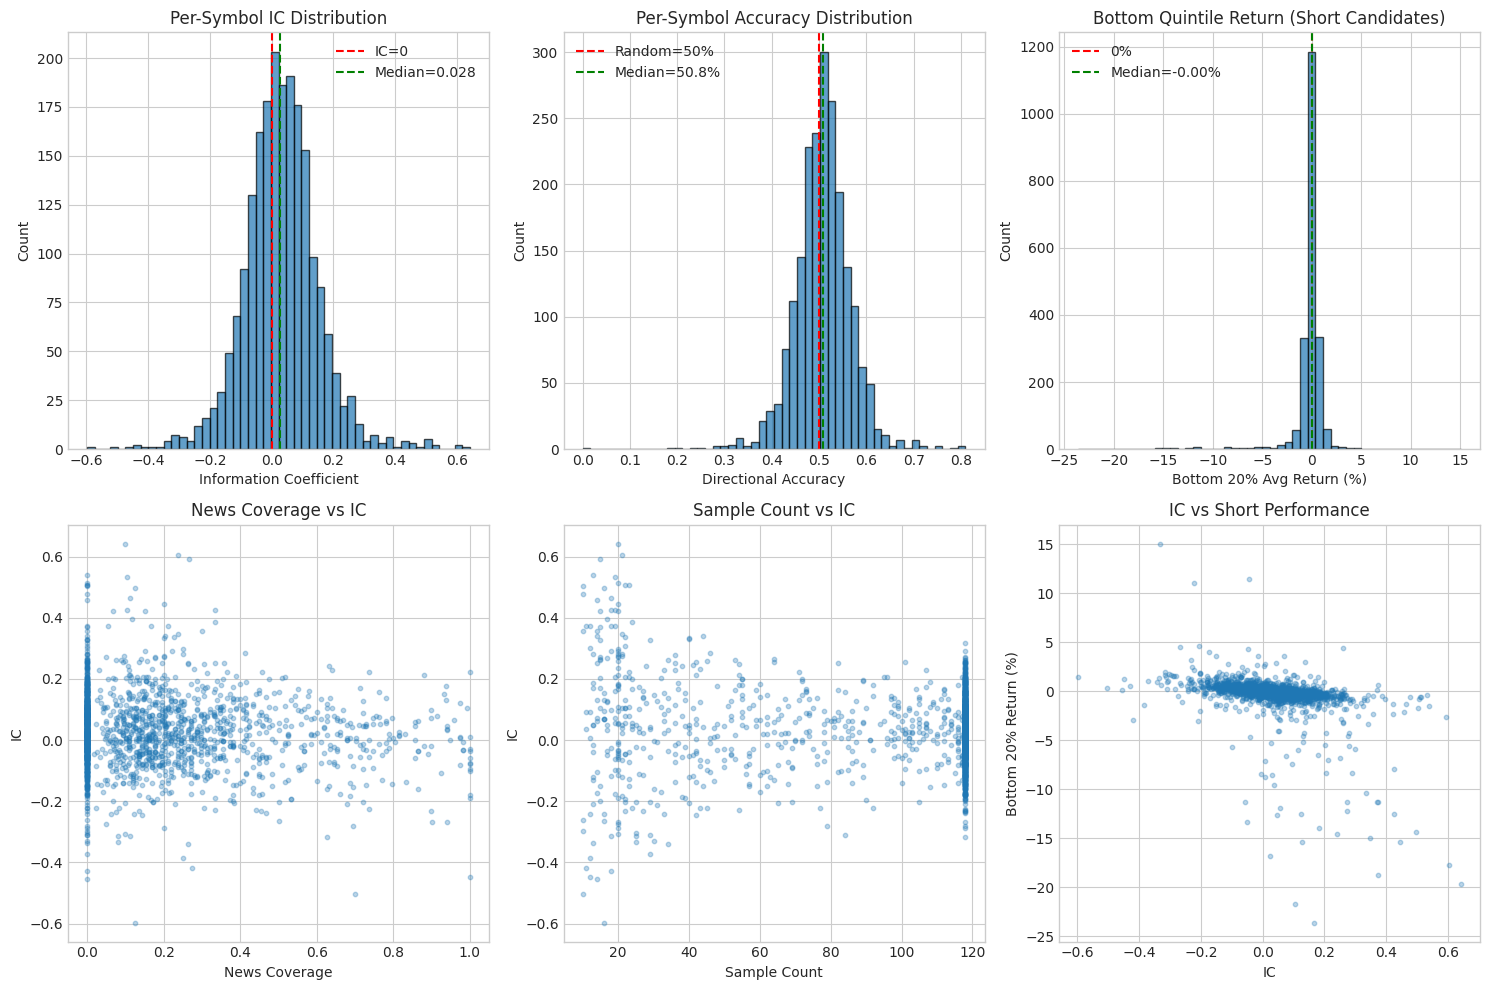

In [28]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# IC distribution
ax = axes[0, 0]
ax.hist(symbol_metrics['ic'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='IC=0')
ax.axvline(symbol_metrics['ic'].median(), color='green', linestyle='--', label=f'Median={symbol_metrics["ic"].median():.3f}')
ax.set_xlabel('Information Coefficient')
ax.set_ylabel('Count')
ax.set_title('Per-Symbol IC Distribution')
ax.legend()

# Accuracy distribution
ax = axes[0, 1]
ax.hist(symbol_metrics['accuracy'], bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0.5, color='red', linestyle='--', label='Random=50%')
ax.axvline(symbol_metrics['accuracy'].median(), color='green', linestyle='--', label=f'Median={symbol_metrics["accuracy"].median():.1%}')
ax.set_xlabel('Directional Accuracy')
ax.set_ylabel('Count')
ax.set_title('Per-Symbol Accuracy Distribution')
ax.legend()

# Bottom 20% return distribution
ax = axes[0, 2]
returns = symbol_metrics['bottom_20_return'].dropna() * 100
ax.hist(returns, bins=50, edgecolor='black', alpha=0.7)
ax.axvline(0, color='red', linestyle='--', label='0%')
ax.axvline(returns.median(), color='green', linestyle='--', label=f'Median={returns.median():.2f}%')
ax.set_xlabel('Bottom 20% Avg Return (%)')
ax.set_ylabel('Count')
ax.set_title('Bottom Quintile Return (Short Candidates)')
ax.legend()

# News coverage vs IC
ax = axes[1, 0]
ax.scatter(symbol_metrics['news_coverage'], symbol_metrics['ic'], alpha=0.3, s=10)
ax.set_xlabel('News Coverage')
ax.set_ylabel('IC')
ax.set_title('News Coverage vs IC')

# Sample count vs IC
ax = axes[1, 1]
ax.scatter(symbol_metrics['n_samples'], symbol_metrics['ic'], alpha=0.3, s=10)
ax.set_xlabel('Sample Count')
ax.set_ylabel('IC')
ax.set_title('Sample Count vs IC')

# IC vs Bottom 20% return
ax = axes[1, 2]
ax.scatter(symbol_metrics['ic'], symbol_metrics['bottom_20_return'] * 100, alpha=0.3, s=10)
ax.set_xlabel('IC')
ax.set_ylabel('Bottom 20% Return (%)')
ax.set_title('IC vs Short Performance')

plt.tight_layout()
plt.show()

## 4. Filter Criteria

In [29]:
# Try different filter thresholds
filters = {
    'all': symbol_metrics,
    'ic > 0': symbol_metrics[symbol_metrics['ic'] > 0],
    'ic > 0.05': symbol_metrics[symbol_metrics['ic'] > 0.05],
    'ic > 0.10': symbol_metrics[symbol_metrics['ic'] > 0.10],
    'bottom_20 < 0': symbol_metrics[symbol_metrics['bottom_20_return'] < 0],
    'bottom_20 < -0.5%': symbol_metrics[symbol_metrics['bottom_20_return'] < -0.005],
    'accuracy > 50%': symbol_metrics[symbol_metrics['accuracy'] > 0.5],
    'accuracy > 55%': symbol_metrics[symbol_metrics['accuracy'] > 0.55],
    'news > 50%': symbol_metrics[symbol_metrics['news_coverage'] > 0.5],
}

print(f"{'Filter':<20} {'Symbols':>10} {'% of Total':>12}")
print("-" * 45)
for name, filtered in filters.items():
    pct = len(filtered) / len(symbol_metrics) * 100
    print(f"{name:<20} {len(filtered):>10,} {pct:>11.1f}%")

Filter                  Symbols   % of Total
---------------------------------------------
all                       2,075       100.0%
ic > 0                    1,268        61.1%
ic > 0.05                   879        42.4%
ic > 0.10                   509        24.5%
bottom_20 < 0             1,039        50.1%
bottom_20 < -0.5%           377        18.2%
accuracy > 50%            1,164        56.1%
accuracy > 55%              407        19.6%
news > 50%                  197         9.5%


In [30]:
# Combined filters
combined_filters = {
    'ic>0 & news>50%': symbol_metrics[(symbol_metrics['ic'] > 0) & (symbol_metrics['news_coverage'] > 0.5)],
    'ic>0.05 & news>50%': symbol_metrics[(symbol_metrics['ic'] > 0.05) & (symbol_metrics['news_coverage'] > 0.5)],
    'bottom<0 & news>50%': symbol_metrics[(symbol_metrics['bottom_20_return'] < 0) & (symbol_metrics['news_coverage'] > 0.5)],
    'ic>0 & bottom<0': symbol_metrics[(symbol_metrics['ic'] > 0) & (symbol_metrics['bottom_20_return'] < 0)],
    'ic>0.05 & acc>50%': symbol_metrics[(symbol_metrics['ic'] > 0.05) & (symbol_metrics['accuracy'] > 0.5)],
}

print(f"\n{'Combined Filter':<25} {'Symbols':>10} {'% of Total':>12}")
print("-" * 50)
for name, filtered in combined_filters.items():
    pct = len(filtered) / len(symbol_metrics) * 100
    print(f"{name:<25} {len(filtered):>10,} {pct:>11.1f}%")


Combined Filter              Symbols   % of Total
--------------------------------------------------
ic>0 & news>50%                  106         5.1%
ic>0.05 & news>50%                64         3.1%
bottom<0 & news>50%               76         3.7%
ic>0 & bottom<0                  827        39.9%
ic>0.05 & acc>50%                746        36.0%


## 5. Backtest with Filtered Universe

In [31]:
# Select filter for backtesting
# Adjust this based on the analysis above
FILTER_NAME = 'ic > 0'
selected_symbols = set(filters[FILTER_NAME].index)
print(f"Selected {len(selected_symbols):,} symbols using filter: {FILTER_NAME}")

Selected 1,268 symbols using filter: ic > 0


In [32]:
# Quick backtest on test set with filtered universe
test_df = df[df['date'].isin(test_dates)].copy()
test_df['score'] = model.score(test_df)

def simple_backtest(df, symbols, k=5):
    """Simple daily short backtest."""
    # Filter to symbols
    df = df[df['symbol'].isin(symbols)].copy()
    
    daily_returns = []
    for date, group in df.groupby('date'):
        if len(group) < k:
            continue
        # Short bottom-K
        bottom_k = group.nsmallest(k, 'score')
        daily_ret = -bottom_k['target_return'].mean()  # Negative for short
        daily_returns.append({'date': date, 'return': daily_ret})
    
    ret_df = pd.DataFrame(daily_returns)
    ret_df['cumulative'] = (1 + ret_df['return']).cumprod()
    
    total_ret = ret_df['cumulative'].iloc[-1] - 1
    sharpe = ret_df['return'].mean() / ret_df['return'].std() * np.sqrt(252)
    max_dd = (ret_df['cumulative'] / ret_df['cumulative'].cummax() - 1).min()
    
    return {
        'total_return': total_ret,
        'sharpe': sharpe,
        'max_dd': max_dd,
        'n_days': len(ret_df),
        'ret_df': ret_df,
    }

In [33]:
# Compare filtered vs unfiltered
all_symbols = set(symbol_metrics.index)

results = {}
for name, syms in [('All symbols', all_symbols), (FILTER_NAME, selected_symbols)]:
    res = simple_backtest(test_df, syms, k=5)
    results[name] = res
    print(f"\n{name} ({len(syms):,} symbols):")
    print(f"  Total Return: {res['total_return']*100:.1f}%")
    print(f"  Sharpe: {res['sharpe']:.2f}")
    print(f"  Max DD: {res['max_dd']*100:.1f}%")
    print(f"  Trading days: {res['n_days']}")


All symbols (2,075 symbols):
  Total Return: 9384.5%
  Sharpe: 2.71
  Max DD: -49.1%
  Trading days: 238

ic > 0 (1,268 symbols):
  Total Return: 5305.4%
  Sharpe: 2.53
  Max DD: -49.0%
  Trading days: 238


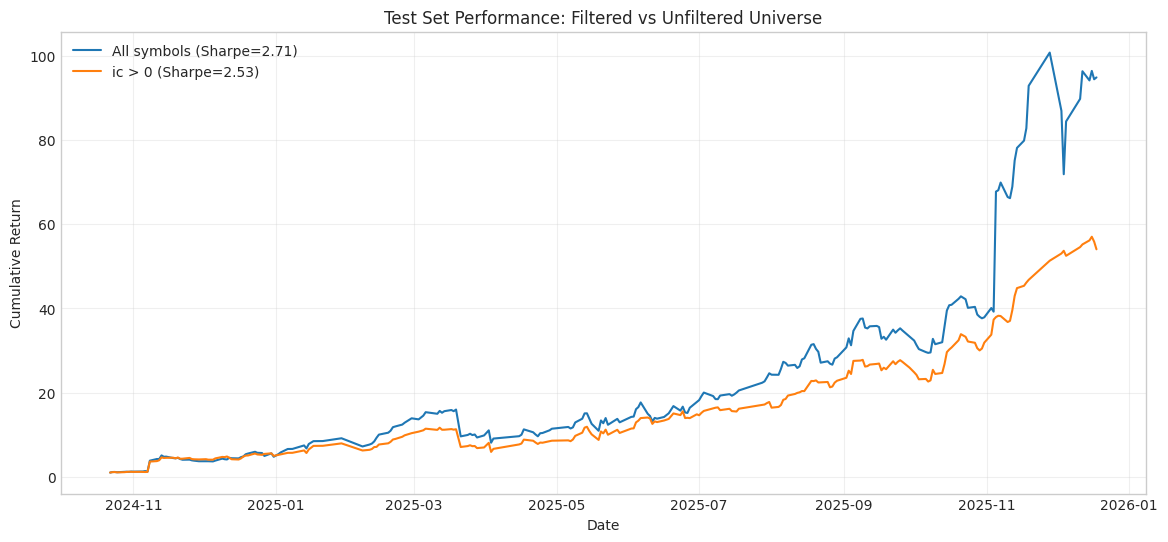

In [34]:
# Plot equity curves
fig, ax = plt.subplots(figsize=(14, 6))

for name, res in results.items():
    ret_df = res['ret_df']
    ax.plot(ret_df['date'], ret_df['cumulative'], label=f"{name} (Sharpe={res['sharpe']:.2f})")

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Test Set Performance: Filtered vs Unfiltered Universe')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

## 6. Grid Search Filters

In [35]:
# Grid search over IC thresholds
ic_thresholds = [-0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2]

grid_results = []
for ic_thresh in ic_thresholds:
    syms = set(symbol_metrics[symbol_metrics['ic'] > ic_thresh].index)
    if len(syms) < 10:
        continue
    res = simple_backtest(test_df, syms, k=5)
    grid_results.append({
        'ic_threshold': ic_thresh,
        'n_symbols': len(syms),
        **{k: v for k, v in res.items() if k != 'ret_df'}
    })

grid_df = pd.DataFrame(grid_results)
print(grid_df.to_string(index=False))

 ic_threshold  n_symbols  total_return   sharpe    max_dd  n_days
        -0.10       1846    155.002316 2.908140 -0.491415     238
        -0.05       1620     88.670523 2.720193 -0.499961     238
         0.00       1268     53.054153 2.525653 -0.490421     238
         0.05        879     16.740540 3.814751 -0.309158     238
         0.10        509     21.926477 4.153687 -0.346713     238
         0.15        269     14.205366 3.753990 -0.306979     238
         0.20        131      3.626741 2.461832 -0.289071     238


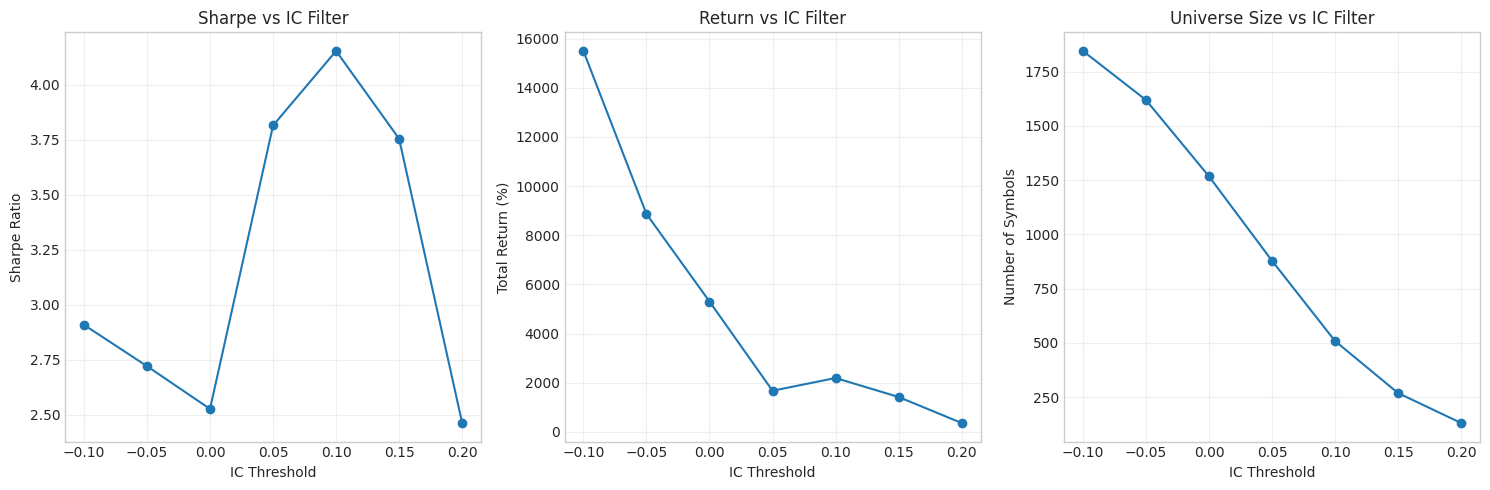

In [36]:
# Plot grid search results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax = axes[0]
ax.plot(grid_df['ic_threshold'], grid_df['sharpe'], 'o-')
ax.set_xlabel('IC Threshold')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe vs IC Filter')
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(grid_df['ic_threshold'], grid_df['total_return'] * 100, 'o-')
ax.set_xlabel('IC Threshold')
ax.set_ylabel('Total Return (%)')
ax.set_title('Return vs IC Filter')
ax.grid(True, alpha=0.3)

ax = axes[2]
ax.plot(grid_df['ic_threshold'], grid_df['n_symbols'], 'o-')
ax.set_xlabel('IC Threshold')
ax.set_ylabel('Number of Symbols')
ax.set_title('Universe Size vs IC Filter')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 7. Save Filtered Universe

In [37]:
# Choose best filter based on analysis
FINAL_IC_THRESHOLD = 0.0  # Adjust based on grid search results

filtered_universe = symbol_metrics[symbol_metrics['ic'] > FINAL_IC_THRESHOLD].copy()
print(f"Final universe: {len(filtered_universe):,} symbols (IC > {FINAL_IC_THRESHOLD})")

Final universe: 1,268 symbols (IC > 0.0)


In [38]:
# Save symbol metrics and filtered list
symbol_metrics.to_parquet(DATA_DIR / 'symbol_metrics_val.pqt')
print(f"Saved symbol metrics to {DATA_DIR / 'symbol_metrics_val.pqt'}")

# Save filtered universe as CSV for easy editing
filtered_list = pd.DataFrame({'symbol': filtered_universe.index})
filtered_list.to_csv(DATA_DIR / 'universe_filtered.csv', index=False)
print(f"Saved filtered universe ({len(filtered_list)} symbols) to {DATA_DIR / 'universe_filtered.csv'}")

Saved symbol metrics to data/symbol_metrics_val.pqt
Saved filtered universe (1268 symbols) to data/universe_filtered.csv
